In [1]:
import fitsio
import proplot as pplt
import numpy as np
import glob
import tqdm
import sys

In [2]:
fnames = glob.glob("./results_pgauss_mdet/meas*.fits")

d = []
for fname in tqdm.tqdm(fnames, ncols=79):
    d.append(fitsio.read(fname, ext="data"))
d = np.concatenate(d)

aps = fitsio.read(fname, ext="aps")

sys.stderr.flush()
sys.stdout.flush()
print("# of objects (millions):", d.shape[0]/1e6/len(aps)/3)

obj_ids = np.arange(d.shape[0], dtype=int) // (len(aps)*3)
nobjs = np.max(obj_ids) + 1

100%|████████████████████████████████████████████| 7/7 [00:29<00:00,  4.23s/it]


# of objects (millions): 1.3781999999999999


In [3]:
import joblib


def _resample_objs(x, obj_ids, func, n=100, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    
    cids = np.unique(obj_ids, return_inverse=True)[1]
    mcid = np.max(cids) + 1
    
    vals = []
    for _ in range(n):
        _cids = rng.choice(mcid, size=mcid, replace=True)
        msk = np.isin(cids, _cids)
        vals.append(func(x[msk]))
    return np.mean(vals, axis=0), np.std(vals, axis=0)


def _eff_n(w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    return neff

def _eff_var(x, w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    seff = np.sum((x*w)**2)/nrm2
    return seff/neff

def _eff_sne(x, w):
    nrm2 = np.sum(w*w)
    seff = np.sum((x*w)*(x*w))/nrm2
    return np.sqrt(seff)


def _compute_stats(d):
    msk_1p = d["mdet_step"] == "1p"
    msk_1m = d["mdet_step"] == "1m"
    msk = d["mdet_step"] == "noshear"

    R = (np.mean(d["e1"][msk_1p]) - np.mean(d["e1"][msk_1m]))/0.02
    e1 = d["e1"][msk] / R
    e1_err = d["e1_err"][msk] / R
    w = 1.0/(e1_err**2 + np.std(e1)**2)

    return [
        R, _eff_n(w), _eff_sne(e1, w), _eff_var(e1, w), 
        np.percentile(d["redshift"][msk], 50),
        np.percentile(d["s2n"][msk], 50),
    ]   


def _meas_ap(ap, min_s2n, max_s2n, tcut, d, obj_ids, rng):
    msk_noshear = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "noshear")
        & (d["ap"] == ap)
    )

    msk_1p = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "1p")
        & (d["ap"] == ap)
    )

    msk_1m = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "1m")
        & (d["ap"] == ap)
    )

    msk = msk_1p | msk_1m | msk_noshear

    rr = _resample_objs(d[msk], obj_ids[msk], _compute_stats, n=100, rng=rng)
    return dict(
        ap=ap,
        Rs=(rr[0][0], rr[1][0]),
        eff_n=(rr[0][1], rr[1][1]),
        sne=(rr[0][2], rr[1][2]),
        prec=(rr[0][3], rr[1][3]),
        redshift=(rr[0][4], rr[1][4]),
        med_s2n=(rr[0][5], rr[1][5])
    )

max_s2n = 1e8
min_s2n = 10
tcut = 0.5

with joblib.Parallel(n_jobs=8, verbose=100) as par:
    outputs = par(
        joblib.delayed(_meas_ap)(
            ap, min_s2n, max_s2n, tcut, d, obj_ids, np.random.RandomState(seed=i+10),
        )
        for i, ap in enumerate(aps)
    )

sne = np.array([o["sne"] for o in outputs])
med_s2n = np.array([o["med_s2n"] for o in outputs])
prec = np.array([o["prec"] for o in outputs])
eff_n = np.array([o["eff_n"] for o in outputs])
aps_plt = np.array([o["ap"] for o in outputs])
redshifts = np.array([o["redshift"] for o in outputs])
Rs = np.array([o["Rs"] for o in outputs])
        
sys.stderr.flush()
sys.stdout.flush()

print("redshifts:", redshifts[:, 0])
print("sne:", sne[:, 0])
print("n_eff:", eff_n[:, 0])
print("R:", Rs[:])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   49.4s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   50.2s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   50.7s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   50.7s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   51.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   51.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   51.3s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   51.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  1.6min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  12 out of  25 | elapsed:  1.6min remaining:  1.7min
[Parallel(n_jobs=8)]: Done  13 out of  25 | elapsed:  1.6min remaining:  1.5min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  1.6min remaining:  1.

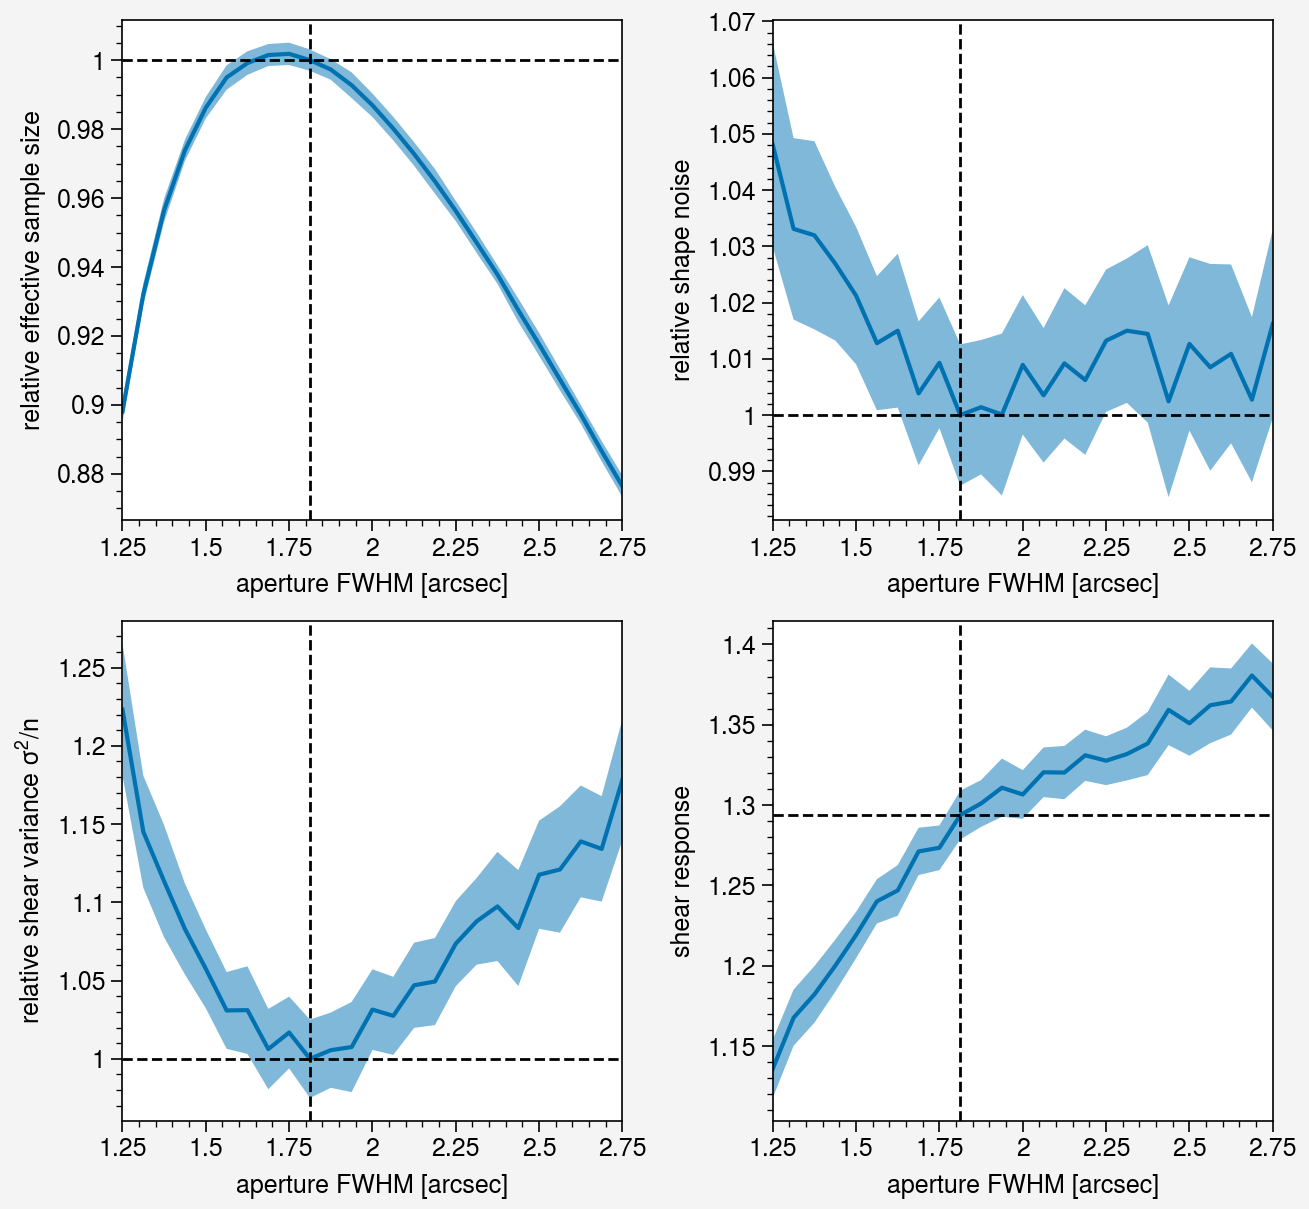

In [4]:
def _errplot(ax, x, ar, hval=1):
    ax.plot(
        x,
        ar[:, 0],
    )
    ax.fill_between(
        x,
        ar[:, 0] - ar[:, 1]*3,
        ar[:, 0] + ar[:, 1]*3,
        alpha=0.5
    )
    ax.grid(False)
    ax.axhline(hval, color='k', linestyle='dashed', lw=1)
    ax.axvline(max_ap, color='k', linestyle='dashed', lw=1)


fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

max_ap = 1.75
ind = np.where(np.array(aps_plt) == max_ap)[0][0] + 1
max_ap = aps_plt[ind]

_errplot(axs[0, 0], aps_plt, eff_n/np.max(eff_n[ind, 0]))
axs[0, 0].set_ylabel("relative effective sample size")
axs[0, 0].set_xlabel("aperture FWHM [arcsec]")

_errplot(axs[0, 1], aps_plt, sne / np.min(sne[ind, 0]))
axs[0, 1].set_ylabel("relative shape noise")
axs[0, 1].set_xlabel("aperture FWHM [arcsec]")

_errplot(axs[1, 0], aps_plt, prec/np.min(prec[ind, 0]))
axs[1, 0].set_ylabel(r"relative shear variance $\sigma^{2}/n$")
axs[1, 0].set_xlabel("aperture FWHM [arcsec]")

_errplot(axs[1, 1], aps_plt, Rs, hval=Rs[ind, 0])
axs[1, 1].set_ylabel("shear response")
axs[1, 1].set_xlabel("aperture FWHM [arcsec]")

fig.savefig("optap.pdf")

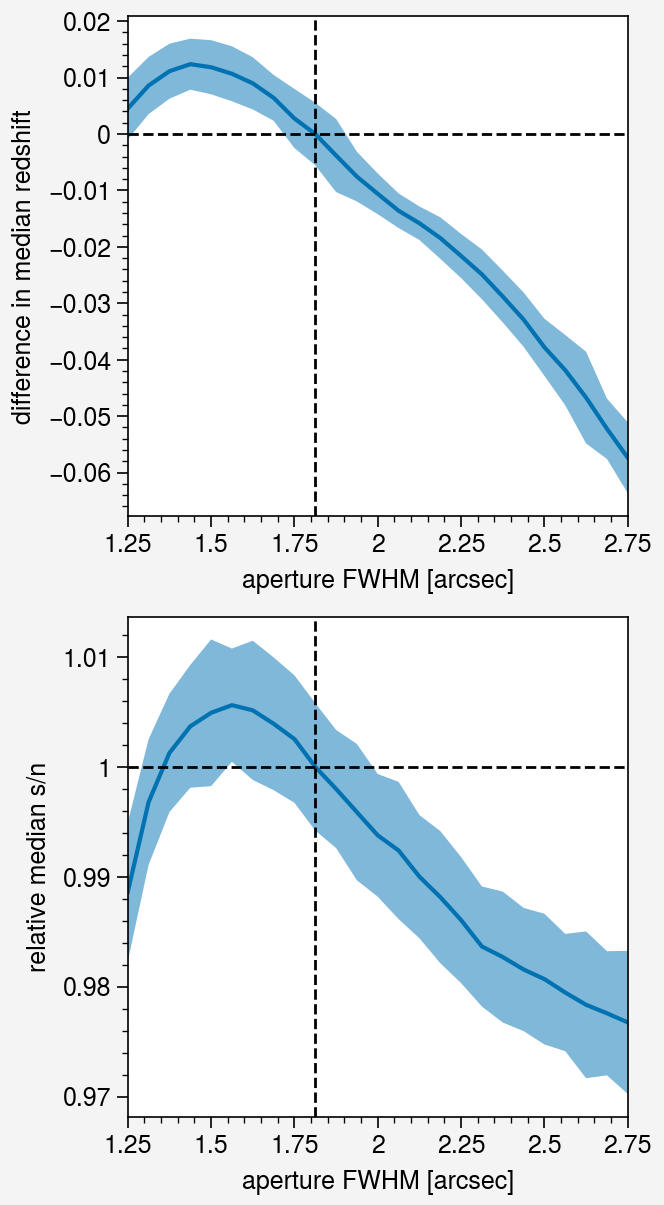

In [5]:
def _errplot(ax, x, ar, hval=1):
    ax.plot(
        x,
        ar[:, 0],
    )
    ax.fill_between(
        x,
        ar[:, 0] - ar[:, 1]*3,
        ar[:, 0] + ar[:, 1]*3,
        alpha=0.5
    )
    ax.grid(False)
    ax.axhline(hval, color='k', linestyle='dashed', lw=1)
    ax.axvline(max_ap, color='k', linestyle='dashed', lw=1)


fig, axs = pplt.subplots(nrows=2, ncols=1, share=0)

sz = redshifts.copy()
sz[:, 0] = sz[:, 0] - redshifts[ind, 0]
_errplot(axs[0, 0], aps_plt, sz, hval=0)
axs[0, 0].set_ylabel("difference in median redshift")
axs[0, 0].set_xlabel("aperture FWHM [arcsec]")

_errplot(axs[1, 0], aps_plt, med_s2n/np.max(med_s2n[ind, 0]))
axs[1, 0].set_ylabel("relative median s/n")
axs[1, 0].set_xlabel("aperture FWHM [arcsec]")

fig.savefig("optap_depth.pdf")